<div id="container" style="position:relative;">
<div style="float:left"><h1> BrainStation Capstone </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

### *Brain tumor detection via Machine learning*

`Notebook 2: Testing out the Logistic Regression Model` <br>
Author: Bilal Munir <br>
Date: June, 2023

## Table of Contents
- 0.0 [Introduction](#Intro)
- 1.0 [Loading in the data](#Loading-in-the-Data)
- 2.0 [Testing out the base model](#Testing-out-the-base-model)
  - 2.1 [Testing logreg (C=1e-07)](#Testing-logreg-(C=1e-07))
  - 2.2 [Testing logreg (C=1e-05)](#Testing-logreg-(C=1e-05))
- 3.0 [Threshold Evaluation](#Threshold-Evaluation)
- 4.0 [Plotting out the coefficients](#Plotting-out-the-coefficients)

## Intro
This notebook:
- Tests out the **Logistic Regression (LR)** model
  - Tests the base LR model
  - Tunes model by training on validation sets
- Evaluates the final model by building a confusion matrix and classification report
- Experiment with the prediction threshold
- Plotting out the coefficients of the best logreg model to determine tumor hotspots

## Loading in the Data
Similar to the previous notebook we start by importing all the libraries. Only this time, the `imgs` variable is defined using the dataframe we saved last time `Tumors_df.csv`.

In [1]:
# Importing the holy quartet of libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Library for importing and opening images
from PIL import Image

# SKLEARN Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Importing the os library to navigate directories to access the data
import os

In [2]:
# Loading the saved tumor dataframe from the 224x224 notebook
tum_df = pd.read_csv('data/Tumors_df.csv')
tum_df.head()

,Tumor_Class,file_path,Tumor_Presence
0,Astrocitoma T1,data/raw/Astrocitoma T1/005_big_gallery.jpeg,1
1,Astrocitoma T1,data/raw/Astrocitoma T1/006_big_gallery.jpeg,1
2,Astrocitoma T1,data/raw/Astrocitoma T1/01809e58d2c1e7fff56cc5...,1
3,Astrocitoma T1,data/raw/Astrocitoma T1/02df132a56dfb89ece42ee...,1
4,Astrocitoma T1,data/raw/Astrocitoma T1/044d8d9984902ca03e652a...,1


In [3]:
file_paths = tum_df['file_path']

In [4]:
imgs = []

for path in file_paths:
        
    # Opening the images
    img = Image.open(path)
        
    # Resizing the images to 224x224
    img = img.resize((224, 224))
        
    # Converting images to grayscale
    img = img.convert(mode='L')
        
    # Loading the normalized image
    load_img = np.asarray(img)
        
    # then append grayscaled images
    imgs.append(load_img)

In [5]:
stacked_images = np.stack(imgs, axis=0)
stacked_images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [6]:
stacked_images.shape

(4479, 224, 224)

In [7]:
X = stacked_images.reshape(-1, 224*224)
y = tum_df['Tumor_Presence']

**Overall gameplan for modelling:**
- Train test Split (done)
- Try out different classification models. 
    - (Logreg & XG-Boost(D-Trees))
    - CNNs

## Testing out the base model

Splitting the data into train, test and validation sets. Not forgetting to stratify the y's so that they are divided properly

In [8]:
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.20, stratify=y_rem, random_state=24)

In [9]:
# Instantiating the Logreg model
logreg = LogisticRegression(max_iter=1000)

# Fitting the model
results = logreg.fit(X_train, y_train)

# Getting the train and validation accuracies
logreg_train_acc = logreg.score(X_train, y_train)
logreg_val_acc = logreg.score(X_val, y_val)

print(f"Train accuracy: {round(logreg_train_acc, 4)}")   
print(f"Val accuracy: {round(logreg_val_acc, 4)}")

Train accuracy: 1.0
Val accuracy: 0.942


This is quite a high validation accuracy. Further investigation is required in order to be certain. Lets see how this model behaves around different regularizations (C-values)

C=1e-08 completed
C=1e-07 completed
C=1e-06 completed
C=1e-05 completed
C=0.0001 completed
C=0.001 completed
C=0.1 completed
C=1.0 completed
C=10.0 completed
C=100.0 completed
C=1000.0 completed
C=10000.0 completed
C=100000.0 completed
C=1000000.0 completed
C=10000000.0 completed
C=100000000.0 completed
C=1000000000.0 completed


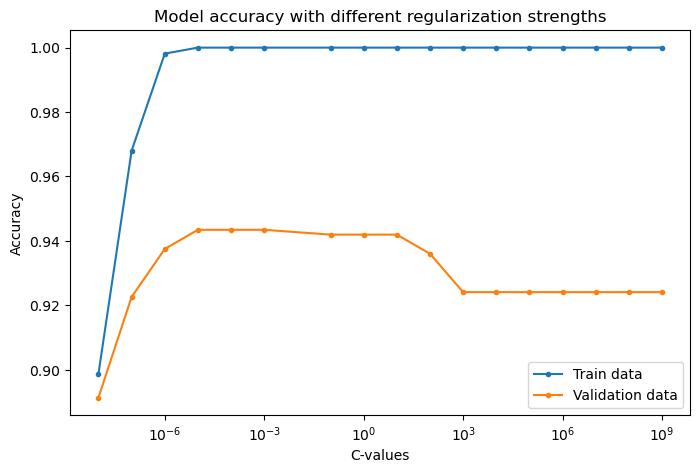

In [10]:
# range of c-values
c_values = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# train/val accuracy lists
train_acc = []
val_acc = []

# loop model iterations across all C-values
for c in c_values:
    logit_C = LogisticRegression(max_iter=10000, C=c, random_state=1).fit(X_train, y_train)
    train_acc.append(logit_C.score(X_train, y_train))
    val_acc.append(logit_C.score(X_val, y_val))
    print(f"C={c} completed")

# plot out train/val accuracies
plt.figure(figsize=(8,5))
plt.plot(c_values, train_acc, marker='.', label='Train data')
plt.plot(c_values, val_acc, marker='.', label='Validation data')
plt.xscale('log')
plt.xlabel('C-values')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model accuracy with different regularization strengths')
plt.show()

**C=1e-07** and **C=1e-05** are definitely the models that deserve to be Tested on the **test set**. The reason being that these have the least amount of overfitting and provide some of the highest validation scores.

### Testing logreg (C=1e-07)

In [11]:
# Instantiating and fitting the IDEAL Logreg model
logreg_1 = LogisticRegression(C=1e-07, max_iter=10000, random_state=1).fit(X_train, y_train)

# Getting the train and validation accuracies
logreg_train_acc = logreg_1.score(X_train, y_train)
logreg_val_acc = logreg_1.score(X_val, y_val)
logreg_test_acc = logreg_1.score(X_test, y_test)

print(f"Number of Iterations: {logreg_1.n_iter_}")
print(f"Train accuracy: {round(logreg_train_acc, 4)}")   
print(f"Val accuracy: {round(logreg_val_acc, 4)}")
print(f"Test accuracy: {round(logreg_test_acc, 4)}")

Number of Iterations: [313]
Train accuracy: 0.968
Val accuracy: 0.9226
Test accuracy: 0.9295


Generating the **confusion matrix** as well as the **classification report**

In [12]:
y_preds1 = logreg_1.predict(X_test)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds1)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-Tumor", "Predicted Tumor"],
    index=["True Non-Tumor", "True Tumor"]
)

display(cf_df)

,Predicted Non-Tumor,Predicted Tumor
True Non-Tumor,63,68
True Tumor,11,978


In [14]:
from sklearn.metrics import classification_report

target_names = ['No Tumor', 'Tumor']
print(classification_report(y_test, y_preds1, target_names=target_names))

              precision    recall  f1-score   support

    No Tumor       0.85      0.48      0.61       131
       Tumor       0.93      0.99      0.96       989

    accuracy                           0.93      1120
   macro avg       0.89      0.73      0.79      1120
weighted avg       0.93      0.93      0.92      1120



#### According to the recall scores:
So this model is able to classify the **True Brains with Tumors CORRECTLY 99% of the time** <br>
While for true **brains without tumors** it is only able to classify **48% correctly**.

Lets try the other model.

### Testing logreg (C=1e-05)

In [15]:
# Instantiating and fitting the IDEAL Logreg model
logreg_2 = LogisticRegression(C=1e-05, max_iter=10000, random_state=1).fit(X_train, y_train)

# Getting the train and validation accuracies
logreg_train_acc = logreg_2.score(X_train, y_train)
logreg_val_acc = logreg_2.score(X_val, y_val)
logreg_test_acc = logreg_2.score(X_test, y_test)

print(f"Number of Iterations: {logreg_2.n_iter_}")
print(f"Train accuracy: {round(logreg_train_acc, 4)}")   
print(f"Val accuracy: {round(logreg_val_acc, 4)}")
print(f"Test accuracy: {round(logreg_test_acc, 4)}")

Number of Iterations: [360]
Train accuracy: 1.0
Val accuracy: 0.9435
Test accuracy: 0.9384


In [16]:
y_preds2 = logreg_2.predict(X_test)

In [17]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds2)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-Tumor", "Predicted Tumor"],
    index=["True Non-Tumor", "True Tumor"]
)

display(cf_df)

,Predicted Non-Tumor,Predicted Tumor
True Non-Tumor,83,48
True Tumor,21,968


In [18]:
from sklearn.metrics import classification_report

target_names = ['No Tumor', 'Tumor']
print(classification_report(y_test, y_preds2, target_names=target_names))

              precision    recall  f1-score   support

    No Tumor       0.80      0.63      0.71       131
       Tumor       0.95      0.98      0.97       989

    accuracy                           0.94      1120
   macro avg       0.88      0.81      0.84      1120
weighted avg       0.93      0.94      0.94      1120



#### According to the recall scores:
So this model is able to classify the **True Brains with Tumors CORRECTLY 98% of the time** <br>
While for true **brains without tumors** it is able to classify **63% correctly**. A significant improvement from the previous model!

There was a decrease in the precision from 85% to 80%

Lets Try different thresholds with this model and create a curve comparing precision and recall.

## Threshold Evaluation

In [19]:
y_proba = logreg_2.predict_proba(X_test)[:, 1]

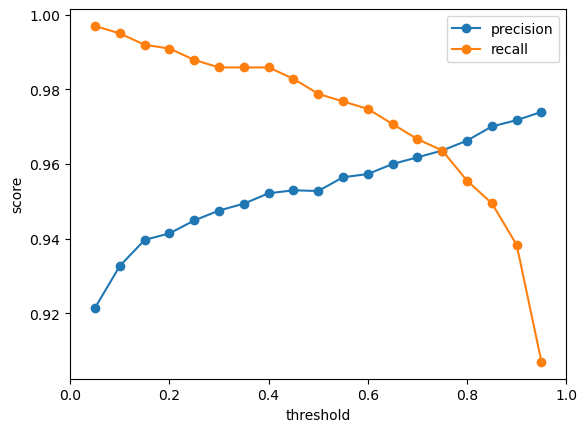

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

The cut off value seems to be at around **0.85**

Lets Try that as our threshold and see if it yields a better confusion matrix. The purpose behind this threshold is that it will classify **`class 1: Tumor`** more often because it is the majority class.

In [30]:
y_pred = (y_proba >= 0.85).astype(int)

In [31]:
len(y_proba >= 0.85)

1120

In [32]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-Tumor", "Predicted Tumor"],
    index=["True Non-Tumor", "True Tumor"]
)

display(cf_df)

,Predicted Non-Tumor,Predicted Tumor
True Non-Tumor,102,29
True Tumor,50,939


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       131
           1       0.97      0.95      0.96       989

    accuracy                           0.93      1120
   macro avg       0.82      0.86      0.84      1120
weighted avg       0.94      0.93      0.93      1120



The precision has suffered a little but what matters is that with the 85% of the test being predicted as **class 1** We can see that more of the minority class, **class 0** is being predicted correctly.

The model has a **final overall accuracy of 93%**

## Plotting out the coefficients
Lets plot out the coefficients of the final Logreg model to see which areas of the images are hotspots for tumors.

In [34]:
logreg_2.coef_

array([[ 1.91038511e-05, -1.55532808e-05, -1.52688489e-05, ...,
         2.00091877e-05,  2.50713437e-05,  6.74660089e-05]])

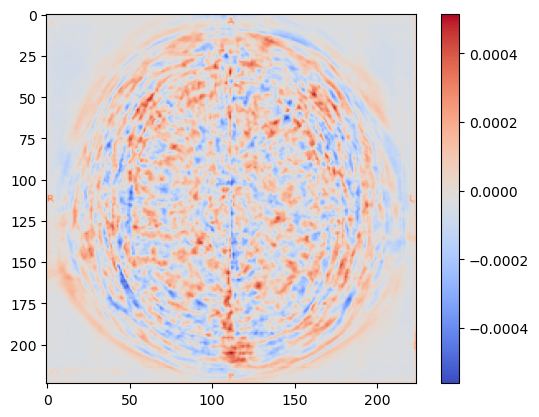

In [35]:
plt.figure()
plt.imshow(logreg_2.coef_.reshape(224, 224), cmap='coolwarm')
plt.colorbar()
plt.show()

This image outlines all the potential areas in an image where a tumor can occur. It is worth paying attention to some of the warmer areas (dark red) since those are the places where tumors are most likely to occur.

Saving the model using **`pickle`**

In [36]:
import pickle

In [38]:
# Save the Model to file in the current working directory

#Pkl_Filename = "Pickled_LR_Model.pkl"  

#with open(Pkl_Filename, 'wb') as file:  
#    pickle.dump(logreg_2, file)